In [1]:
from import_images import KlipRetrieve, PreInjectImages

In [2]:
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import time
import astropy.io.fits as fits


# Load tables

### Original instructions from Simon Petrus

<blockquote>

Here you can find what you need :

- The spectrum of the  star HIP65426 from the Next-Gen models. I calibrate the flux on photometric points found in VOSA. I degraded the resolution to R=10000 on the entire spectrum between 1.0 mic and 5.2 mic. I'm sorry I can't provide you a spectrum at higher wavelengths because after 5.2 mic the resolution of models decreases to few hundreds.

- The spectrum of the planet HIP65426b from the BT-SETTL15 models. This model corresponds to the best fit with data from SPHERE IFS, SPHERE LSS, SINFONI and NACO. I also calibrate the flux as an observed flux and I also degraded its resolution to R=10000 between 1.0mic and 5.2mic. 

For each spectrum the wavelengths are in microns and the fluxes are in W.m-2.mic-1</blockquote>

In [3]:
input_star_0 = fits.open('input_models/stellar_flux_HIP65426_10000_Next_Gen.fits')
input_star = Table([input_star_0[0].data[0],input_star_0[0].data[1]], names=['wavelength', 'flux'])

input_planet_0 = fits.open('input_models/planet_flux_HIP65426_10000_BT_SETTL15.fits')
input_planet = Table([input_planet_0[0].data[0],input_planet_0[0].data[1]], names=['wavelength', 'flux'])

sep_arcsec = 0.80 * u.arcsec

wv_lo = 2.87 * u.micron # from nirspec
wv_hi = 5.27 * u.micron # from nirspec

for t in [input_planet, input_star]:
    t['wavelength'].unit = u.micron
    t['flux'].unit = u.W/u.m**2/u.micron

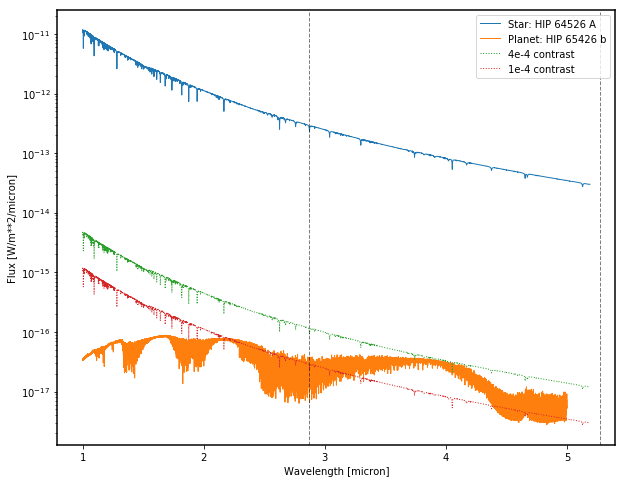

In [4]:
plt.figure(figsize=(10,8))
plt.semilogy(input_star['wavelength'], input_star['flux'], label='Star: HIP 64526 A')
plt.semilogy(input_planet['wavelength'], input_planet['flux'], label='Planet: HIP 65426 b')
plt.semilogy(input_star['wavelength'], input_star['flux']*4e-4, label='4e-4 contrast', ls=':')
plt.semilogy(input_star['wavelength'], input_star['flux']/1e4, label='1e-4 contrast', ls=':')

for wl in [wv_lo, wv_hi]:
    plt.axvline(wl.value, ls='--', color='black', alpha=0.5)
plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [W/m**2/micron]")
plt.legend()

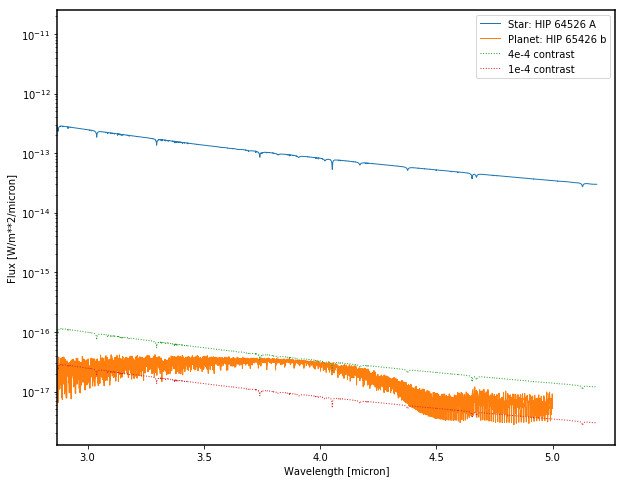

In [5]:
plt.figure(figsize=(10,8))
plt.semilogy(input_star['wavelength'], input_star['flux'], label='Star: HIP 64526 A')
plt.semilogy(input_planet['wavelength'], input_planet['flux'], label='Planet: HIP 65426 b')
plt.semilogy(input_star['wavelength'], input_star['flux']*4e-4, label='4e-4 contrast', ls=':')
plt.semilogy(input_star['wavelength'], input_star['flux']/1e4, label='1e-4 contrast', ls=':')

plt.xlim(wv_lo.value, wv_hi.value)
plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [W/m**2/micron]")
plt.legend()

# Inject a simulated data cube

In this section, I use code from my class that can use the spectra we read in earlier (`new_star` and `new_comp`) to inject a companion into a data cube of simulated NirSpec target observations. It then attempts to subtract the star's flux from the image through KLIP, using another data cube of simulated reference star observations to calculate the PCA basis.

(Note that for now, the star is scaled to have the same brightness in all slices, so the companion's brightness is influenced by changes in both its spectrum *and* the star's spectrum.)

Finally, I provide code to save a PDF with subtraction results plots for all slices of a data cube.

*(if you've imported `KlipRetrieve` and are curious about one of the class methods, put your cursor on it and press `Shift`+`Tab` a couple of times to view the docstrings.)*

In [6]:
#injector = PreInjectImages('/user/jotor/gen_images/30_slice_4_os4')
injector = PreInjectImages('/Users/mperrin/data/ifu_sims/30_slice_4_os4')

In [7]:
cubes_with_comp = injector.inject_companion(injector.data_cubes, 
                          star_spectrum=input_star,
                          comp_spectrum=input_planet,
                          separation=sep_arcsec.value,
                          position_angle = 150) 


********
injecting companion with spectrally defined intensity into unaligned images.
********

********
shifting companion...
********


In [8]:
injector._injected_companion_contrast_spectrum

array([7.29070620e-05, 8.36074394e-05, 1.03583680e-04, 1.24495564e-04,
       1.45720842e-04, 1.77746549e-04, 1.83921874e-04, 2.12931432e-04,
       2.37103876e-04, 2.59669006e-04, 2.83428769e-04, 3.18119633e-04,
       3.35342691e-04, 3.54169898e-04, 3.53827334e-04, 3.56395838e-04,
       3.18237120e-04, 2.80253660e-04, 2.28841369e-04, 1.95200654e-04,
       1.49836176e-04, 1.31932032e-04, 1.36387203e-04, 1.66491657e-04,
       1.57025067e-04, 1.63097103e-04, 1.66924279e-04, 1.79346626e-04,
       1.58868638e-04, 1.66377636e-04])

In [9]:
injector.export_to_new_dir(injector.data_cubes[0:10] + cubes_with_comp, 
                          "test_hip65426")

## Test subtractions and export of subtracted cubes

In [10]:
subtractor = KlipRetrieve("test_hip65426/")

commence removal of dither shifts
(30, 30, 30) data cube shape at beginning
(30, 34, 34) data cube shape at end

[(15, 18), (16, 18), (15, 18), (16, 18), (15, 17), (16, 17), (15, 18), (16, 18), (15, 18), (15, 18)] 
 [(20, 20), (20, 20), (19, 20), (20, 20), (19, 20), (20, 20), (20, 20), (20, 20), (19, 21), (20, 20)]
5 3
(30, 34, 34) data cube shape at beginning
(30, 40, 44) data cube shape at end

(30, 24, 23) data cube shape after removing padding

********
non-padded image shape: (24, 23)
********



********
total intensity pre-subtract:  9.3832e-01
total intensity post-subtract: 6.6412e-03
********


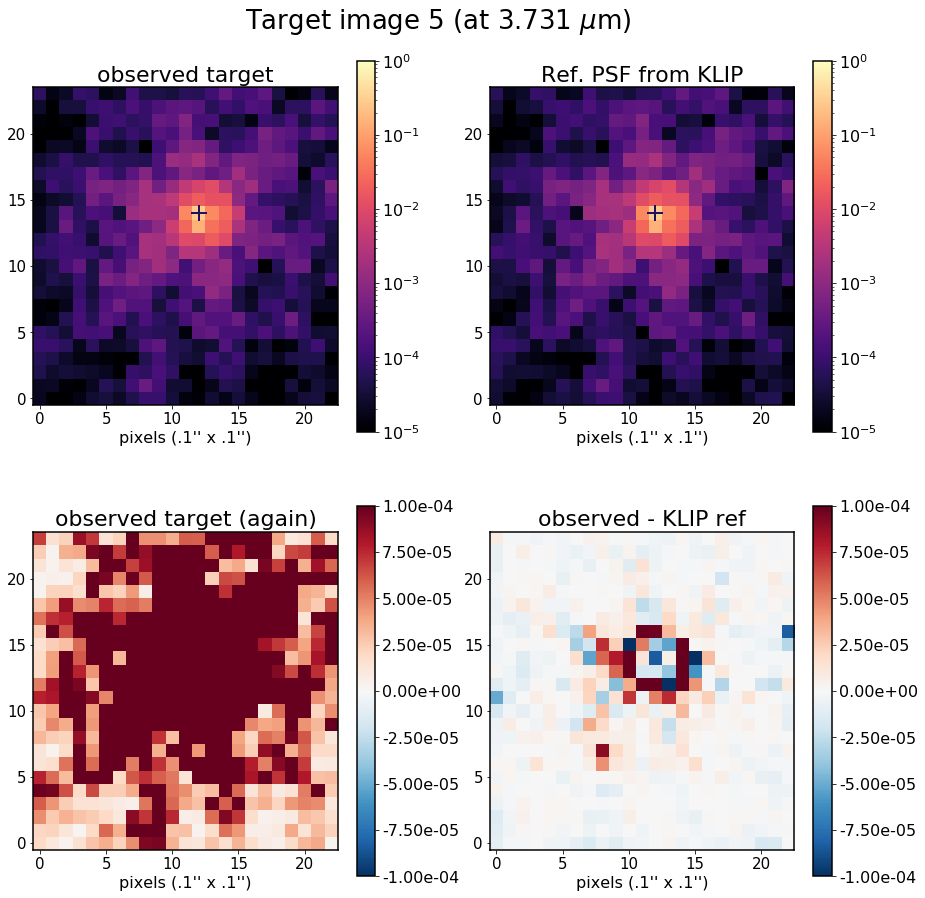

(0.9383213268829358, 0.006641241780103973)

In [11]:
# examine pre and post-subtraction versions of one slice of one injected image
subtractor.plot_subtraction(target_image=5, wv_slice=11, sub_vmax=1e-4)

In [14]:
subtracted = subtractor.export_subtracted_cubes(subtractor.stackable_cubes, 'subtracted_hip65426')

# Use subtracted cubes to plot the companion spectra post subtractions

In [20]:
imagenum = 3

def show_extracted_spectrum(subtracted, imagenum=0, slice=11):

    fig, axes = plt.subplots(figsize=(10,4), ncols=2, gridspec_kw={'width_ratios': [1, 1.5], 'wspace': 0.4})

    axes[0].imshow(subtracted[imagenum].data[slice], vmin=-1e-4, vmax=1e-4)
    px, py = 8,7
    axes[0].scatter([px],[py], marker='o', edgecolors='red', facecolors='none', s=500)
    axes[0].set_xlabel("Pixels")
    axes[0].set_title("Subtracted image at {:.2f} microns\nDither position {}".format(subtractor.wvlnths[slice]*1e6, imagenum))

    axes[1].semilogy(subtractor.wvlnths*1e6, subtracted[imagenum].data[:,py, px], label='Contrast in peak pixel')
    axes[1].semilogy(subtractor.wvlnths*1e6, subtracted[imagenum].data[:,py-1:py+2,px-1:py+2].sum(axis=2).sum(axis=1), color='red', label='Contrast in 3x3 aperture')

    try:
        axes[1].semilogy(injector.wvlnths*1e6, injector._injected_companion_contrast_spectrum, 
                         ls='--', label='Injected companion contrast spectrum')
    except:
        pass

    axes[1].set_xlabel("Wavelength [microns]")
    axes[1].set_ylabel("Contrast")
    axes[1].set_ylim(0, 1e-3)

    axes[1].legend()

/Users/mperrin/software/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


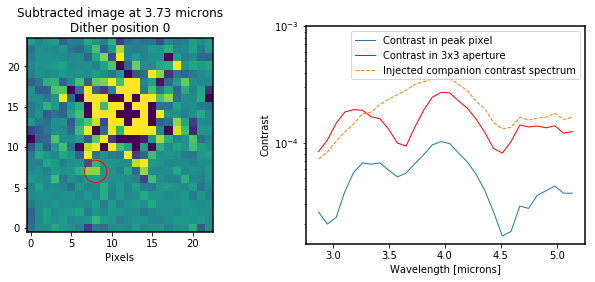

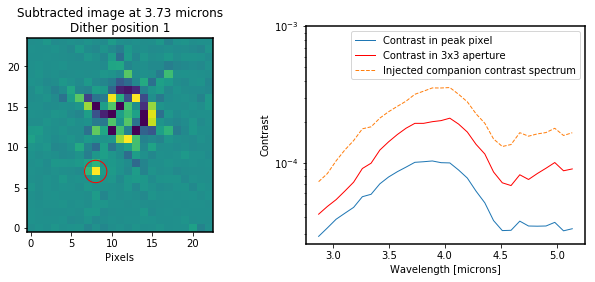

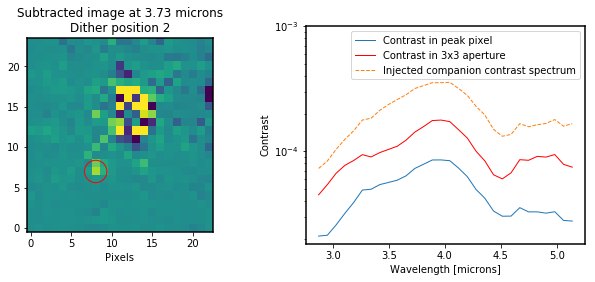

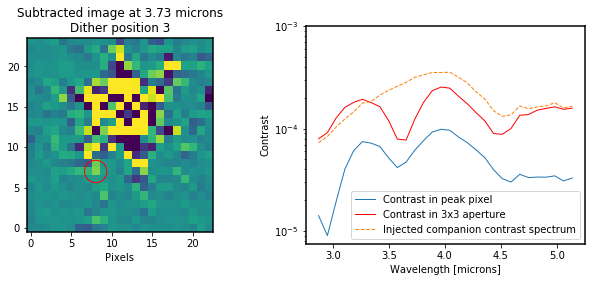

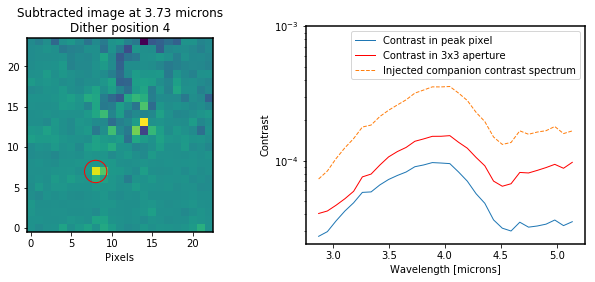

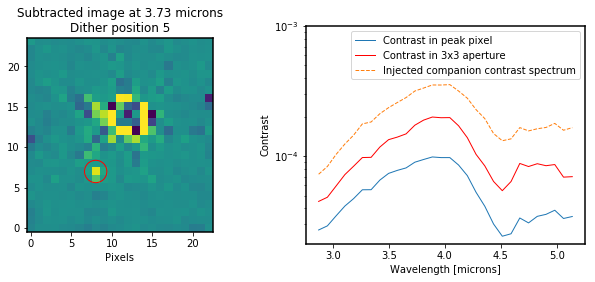

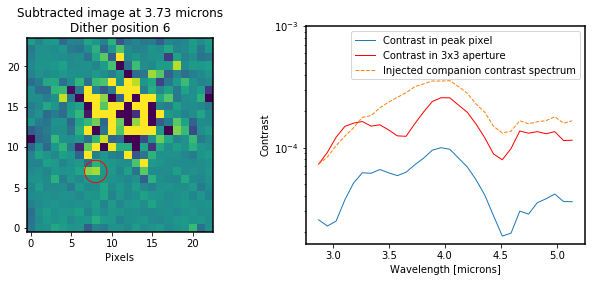

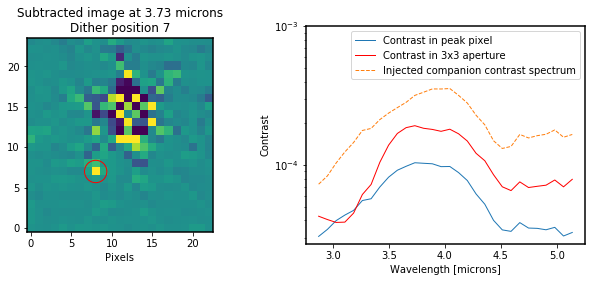

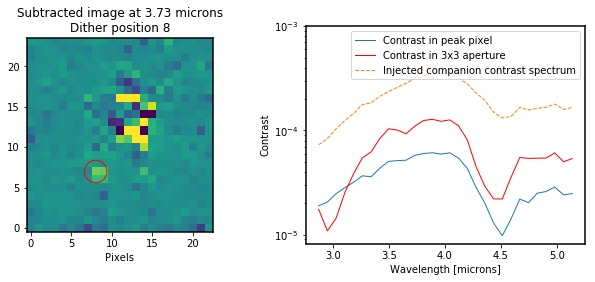

In [21]:
for i in range(9):
    show_extracted_spectrum(subtracted, i)

In [ ]:
def automate_pdf(file_start, companion, num_slices):
    '''
    Create a pdf from plot_subtraction() results. `file_start` is a string version
    of the intended file name (without the '.pdf'), `companion` is a boolean controlling
    whether the images will contain a companion (you probably want True), and `num_slices`
    is the number of slices for which to generate plots. For all slices, just use
    `len(obj.wvlnths)`, where `obj` is your KlipRetrieve instance.
    
    In my tests, it takes about a second to generate a plot, so this will take a long
    time with the full resolution data cube. The one in this example is just 30 slices,
    so it shouldn't take too long.
    '''
    with PdfPages(file_start + '.pdf') as pdf:
        start = time.time()
        for i in range(num_slices):
            fig = kr.plot_subtraction(companion=companion, wv_slice=i, return_plot=True)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        print(time.time() - start, 's')

In [ ]:
automate_pdf('kappa_cube', True, len(kr.wvlnths))

Open the resulting PDF and flip through from page-to-page for an effect similar to opening a FITS file in ds9.